In [ ]:
!pip install tensorflow==1.14
!pip install tensorflow-gpu==1.14
!pip install keras==2.3.1
!pip install bert4keras

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

!ls "/content/drive/My Drive/ner/data"

example.dev  example.test  example.train  ner.dev  ner.train


In [ ]:
import numpy as np
from bert4keras.backend import keras, K
from bert4keras.models import build_transformer_model
from bert4keras.tokenizers import Tokenizer
from bert4keras.optimizers import Adam
from bert4keras.snippets import sequence_padding, DataGenerator
from bert4keras.snippets import open, ViterbiDecoder, to_array
from bert4keras.layers import ConditionalRandomField
from keras.layers import Dense
from keras.models import Model
from tqdm import tqdm
import pandas as pd

In [6]:
# define hyperparameters.
maxlen = 256
epochs = 1
batch_size = 8
bert_layers = 12
learning_rate = 2e-5  
crf_lr_multiplier = 1000  
categories = set()

In [7]:
# Configuration files for pretrained model.
config_path = '/content/drive/My Drive/ner/bert/bert_config.json'
checkpoint_path = '/content/drive/My Drive/ner/bert/bert_model.ckpt'
dict_path = '/content/drive/My Drive/ner/bert/vocab.txt'

In [30]:
def load_data(filename):
    """load data
    format：[text, (start, end, label), (start, end, label), ...]，
              text[start:end + 1] is an entity of type label.
    """
    D = []
    with open(filename, encoding='utf-8') as f:
        f = f.read()
        for l in f.split('\n\n'):
            if not l:
                continue
            d = ['']
            #print(l.split("\n"))
            for i, c in enumerate(l.split('\n')):
                if len(c.split(' ')) != 2:
                    continue
                char, flag = c.split(' ')
                d[0] += char
                if flag[0] == 'B':
                    d.append([i, i, flag[2:]])
                    categories.add(flag[2:])
                elif flag[0] == 'I':
                    d[-1][1] = i
            D.append(d)
    return D

In [31]:
test_data = load_data('/content/drive/My Drive/ner/data/example.test')

In [34]:
train_data = load_data('/content/drive/My Drive/ner/data/example.train')
valid_data = load_data('/content/drive/My Drive/ner/data/example.dev')
test_data = load_data('/content/drive/My Drive/ner/data/example.test')
categories = list(sorted(categories))

In [36]:
print("train data size: {}".format(len(train_data)))
print("valid data size: {}".format(len(valid_data)))
print("test data size: {}".format(len(test_data)))

train data size: 20864
valid data size: 2318
test data size: 4636


In [32]:
categories

{'LOC', 'ORG', 'PER'}

In [83]:
class data_generator(DataGenerator):
    def __iter__(self, random=False):
        batch_token_ids, batch_segment_ids, batch_labels = [], [], []
        for is_end, d in self.sample(random):
            tokens = tokenizer.tokenize(d[0], maxlen=maxlen)
            mapping = tokenizer.rematch(d[0], tokens)
            start_mapping = {j[0]: i for i, j in enumerate(mapping) if j}
            end_mapping = {j[-1]: i for i, j in enumerate(mapping) if j}
            token_ids = tokenizer.tokens_to_ids(tokens)
            segment_ids = [0] * len(token_ids)
            labels = np.zeros(len(token_ids))
            for start, end, label in d[1:]:
                if start in start_mapping and end in end_mapping:
                    start = start_mapping[start]
                    end = end_mapping[end]
                    # print(categories.index(label))
                    # print("start:{}".format(start))
                    # print("end:{}".format(end))
                    labels[start] = categories.index(label) * 2 + 1
                    labels[start + 1:end + 1] = categories.index(label) * 2 + 2
                    # print(labels)
            batch_token_ids.append(token_ids)
            batch_segment_ids.append(segment_ids)
            batch_labels.append(labels)
            if len(batch_token_ids) == self.batch_size or is_end:
                batch_token_ids = sequence_padding(batch_token_ids)
                batch_segment_ids = sequence_padding(batch_segment_ids)
                batch_labels = sequence_padding(batch_labels)
                yield [batch_token_ids, batch_segment_ids], batch_labels
                batch_token_ids, batch_segment_ids, batch_labels = [], [], []

In [ ]:
model = build_transformer_model(
    config_path,
    checkpoint_path,
)

output_layer = 'Transformer-%s-FeedForward-Norm' % (bert_layers - 1)
output = model.get_layer(output_layer).output

# Please add a layer of neural network, the dimension is 512.

#**********

#**********

output = Dense(len(categories) * 2 + 1)(output)
CRF = ConditionalRandomField(lr_multiplier=crf_lr_multiplier)
output = CRF(output)

model = Model(model.input, output)
model.summary()

model.compile(
    loss=CRF.sparse_loss,
    optimizer=Adam(learning_rate),
    metrics=[CRF.sparse_accuracy]
)


# def target_score(self, y_true, y_pred):
#     """
#     point_score = tf.einsum('bni,bni->b', y_true, y_pred) 
#     trans_score = tf.einsum(
#         'bni,ij,bnj->b', y_true[:, :-1], self.trans, y_true[:, 1:]
#     ) 
#     return point_score + trans_score

# def dense_loss(self, y_true, y_pred):
#         mask = K.all(K.greater(y_pred, -1e6), axis=2, keepdims=True)
#         mask = K.cast(mask, K.floatx())
#         y_true, y_pred = y_true * mask, y_pred * mask
#         target_score = self.target_score(y_true, y_pred)
#         init_states = [y_pred[:, 0]]
#         y_pred = K.concatenate([y_pred, mask], axis=2)
#         input_length = K.int_shape(y_pred[:, 1:])[1]
#         log_norm, _, _ = K.rnn(
#             self.log_norm_step,
#             y_pred[:, 1:],
#             init_states,
#             input_length=input_length
#         )  
#         log_norm = K.logsumexp(log_norm, 1)  
#         return log_norm - target_score

#     def sparse_loss(self, y_true, y_pred):
#         y_true = K.reshape(y_true, K.shape(y_pred)[:-1])
#         y_true = K.cast(y_true, 'int32')
#         y_true = K.one_hot(y_true, K.shape(self.trans)[0])
#         return self.dense_loss(y_true, y_pred)

In [88]:
class NamedEntityRecognizer(ViterbiDecoder):
    def recognize(self, text):
        tokens = tokenizer.tokenize(text, maxlen=512)
        mapping = tokenizer.rematch(text, tokens)
        token_ids = tokenizer.tokens_to_ids(tokens)
        segment_ids = [0] * len(token_ids)
        token_ids, segment_ids = to_array([token_ids], [segment_ids])
        nodes = model.predict([token_ids, segment_ids])[0]
        labels = self.decode(nodes)
        entities, starting = [], False
        for i, label in enumerate(labels):
            if label > 0:
                if label % 2 == 1:
                    starting = True
                    entities.append([[i], categories[(label - 1) // 2]])
                elif starting:
                    entities[-1][0].append(i)
                else:
                    starting = False
            else:
                starting = False
        return [(mapping[w[0]][0], mapping[w[-1]][-1], l) for w, l in entities]


In [89]:
NER = NamedEntityRecognizer(trans=K.eval(CRF.trans), starts=[0], ends=[0])

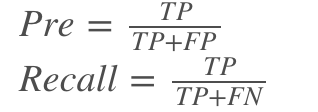

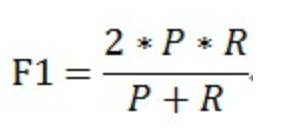

In [90]:
def evaluate(data):
    X, Y, Z = 1e-10, 1e-10, 1e-10
    for d in tqdm(data, ncols=100):
        R = set(NER.recognize(d[0]))
        T = set([tuple(i) for i in d[1:]])
        X += len(R & T) # true predict number.
        Y += len(R) # predict number.
        Z += len(T) # true number.
    f1, precision, recall = 2 * X / (Y + Z), X / Y, X / Z
    return f1, precision, recall


class Evaluator(keras.callbacks.Callback):
    def __init__(self):
        self.best_val_f1 = 0

    def on_epoch_end(self, epoch, logs=None):
        trans = K.eval(CRF.trans)
        NER.trans = trans
        f1, precision, recall = evaluate(valid_data)
        # Save the optimal model.
        if f1 >= self.best_val_f1:
            self.best_val_f1 = f1
            model.save_weights('/content/drive/My Drive/ner/bert/best_model.weights')
        print(
            'valid:  f1: %.5f, precision: %.5f, recall: %.5f, best f1: %.5f\n' %
            (f1, precision, recall, self.best_val_f1)
        )
        f1, precision, recall = evaluate(test_data)
        print(
            'test:  f1: %.5f, precision: %.5f, recall: %.5f\n' %
            (f1, precision, recall)
        )

In [ ]:
flag = "train"
if flag == "train":
    evaluator = Evaluator()
    train_generator = data_generator(train_data, batch_size)
    print(type(train_generator))

    model.fit(
        train_generator.forfit(),
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        callbacks=[evaluator]
    )

else:
    model.load_weights('/content/drive/My Drive/ner/bert/best_model.weights')
    NER.trans = K.eval(CRF.trans)

<class '__main__.data_generator'>



Epoch 1/1
1547/2608 [================>.............] - ETA: 4:46 - loss: 1.6099 - sparse_accuracy: 0.9700

In [ ]:
NER.recognize("A case of pulmonary embolism presenting as recurrent fainting misdiagnosed as coronary heart disease")

[(9, 11, 'ORG'), (14, 16, 'ORG')]

In [5]:
df = pd.read_excel("/content/drive/My Drive/ner/misd2019-2022.xlsx")
df_train = df[:5000]
df_dev = df[5000:]


w_train = open("/content/drive/My Drive/ner/ner.train", "w", encoding="utf-8")
w_dev = open("/content/drive/My Drive/ner/ner.dev", "w", encoding="utf-8")

def write(df, w):
  for _, row in df.iterrows():
      sent = row["title"]
      word_2 = row["TrueDisease"]
      word_3 = row["MisdiagnosedDisease"]
      try:
          s_index = sent.find(word_2)
      except:
          continue
      target_1_index = []
      target_2_index = []
      if s_index == -1:
          continue
      e_index = len(word_2) - 1 + s_index
      target_1_index = [i for i in range(s_index, e_index+1)]
      
      s_index = sent.find(word_3)
      if s_index != -1:
          e_index = len(word_3) - 1 + s_index
          target_2_index =  [i for i in range(s_index, e_index+1)]
      
      j = 0
      index2BIO = dict()
      for i in target_1_index:
          if j == 0:
              index2BIO[i] = "B-ORG"
          else:
              index2BIO[i] = "I-ORG"
              
          j += 1
      
      j = 0
      for i in target_2_index:
          if j == 0:
              index2BIO[i] = "B-ORG"
          else:
              index2BIO[i] = "I-ORG"
              
          j += 1
          
      index = 0
      for word in sent:
          BIO = index2BIO.get(index, "O")
          index += 1
          
          w.write(word + " " + BIO + "\n")
          
      w.write("\n")
          
  w.close()

write(df_train, w_train)
write(df_dev, w_dev)

In [ ]:
evaluator = Evaluator()

In [ ]:
train_data = load_data('/content/drive/My Drive/ner/data/ner.train')
valid_data = load_data('/content/drive/My Drive/ner/data/ner.dev')
test_data = load_data('/content/drive/My Drive/ner/data/ner.dev')

In [ ]:
train_generator = data_generator(train_data, batch_size)

In [ ]:
model.fit(
        train_generator.forfit(),
        steps_per_epoch=len(train_generator),
        epochs=2,
        callbacks=[evaluator]
)

Epoch 1/2
558/558 [==============================] - 88s 158ms/step - loss: 2.2955 - sparse_accuracy: 0.7396
[[ 0.9473287   0.0515274  -4.726325    1.3650935  -6.3565335  -0.11468404
  -4.112891  ]
 [-2.681078   -0.44777942  2.3017228  -2.2286022  -5.998519   -3.1719942
  -4.1608257 ]
 [-1.7708175   0.03332052  2.1540349  -1.4768354  -5.0469046  -0.7964031
  -3.76351   ]
 [-3.343561   -4.1050997  -2.825257   -2.2257075   3.3898852  -2.0895452
  -3.4975882 ]
 [-2.6851478  -2.6905947  -5.4146385  -4.5759325   2.624588   -2.901232
  -5.2661414 ]
 [-2.8323023  -2.7785425  -2.652873   -2.0954735  -4.609475   -2.0388846
   3.181094  ]
 [-1.0997393  -2.154461   -3.2669022  -1.220954   -4.0416374  -1.7901453
   2.9059687 ]]


100%|████████████████████████████████████████████████████████████| 928/928 [00:07<00:00, 118.10it/s]


valid:  f1: 0.80560, precision: 0.81863, recall: 0.79297, best f1: 0.80560



100%|████████████████████████████████████████████████████████████| 928/928 [00:08<00:00, 114.95it/s]


test:  f1: 0.80560, precision: 0.81863, recall: 0.79297

Epoch 2/2
558/558 [==============================] - 85s 152ms/step - loss: 1.3568 - sparse_accuracy: 0.7503
[[ 0.9694787  -0.08834597 -4.823507    1.2361585  -6.832543   -0.26103428
  -4.2393875 ]
 [-2.9463437  -0.44839105  2.261362   -2.265731   -6.007069   -3.1724675
  -4.1620455 ]
 [-1.8707445   0.03318083  2.1467285  -1.483316   -5.048954   -0.79654473
  -3.7641087 ]
 [-3.2942924  -4.119394   -2.9663699  -2.93814     3.2498598  -2.14217
  -3.6520736 ]
 [-2.8494294  -2.7440376  -5.5663376  -4.5575824   2.7009928  -2.9419036
  -5.5266714 ]
 [-3.1005218  -2.7793472  -2.6575413  -2.227333   -4.6723466  -2.0390148
   3.1412127 ]
 [-1.1834795  -2.1545393  -3.2671509  -1.2471675  -4.045811   -1.7901453
   2.9035938 ]]


100%|████████████████████████████████████████████████████████████| 928/928 [00:07<00:00, 119.44it/s]


valid:  f1: 0.81019, precision: 0.82004, recall: 0.80057, best f1: 0.81019



100%|████████████████████████████████████████████████████████████| 928/928 [00:07<00:00, 118.88it/s]

test:  f1: 0.81019, precision: 0.82004, recall: 0.80057



In [ ]:
NER.recognize("A case of pulmonary embolism presenting as recurrent fainting misdiagnosed as coronary heart disease")